# Base

In [33]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
import cv2
import joblib

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.cluster.vq import vq

np.random.seed(0)  # reproducibility
root_dir = '/kaggle/input/hyperkvasir/labeled-images'
ckpt_path = './checkpoints'

os.makedirs(ckpt_path, exist_ok=True)
os.makedirs(f'{ckpt_path}/descriptors/', exist_ok=True)
os.makedirs(f'{ckpt_path}/codebook/', exist_ok=True)

# BoVW class

In [92]:
from typing import Optional

class BagOfVisualWords:
    def __init__(
        self,
        root_dir: str = "/kaggle/input/the-hyper-kvasir-dataset/labeled_images",
        descriptors_lake_path: str = None,
        codebook_dir: str = None,
        
        method: str = 'sift',
        extractor_kwargs: dict = None,
    ):
        """Constructor method
        
        :param descriptors_lake_path: str (optional), path to file including all computed descriptors (vectors)
        :param codebook_dir: str (optional), path to visual vocabulary
        
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(f"{root_dir}/image-labels.csv")
        self.labels = tuple(self.df["Finding"].unique())
        
        # In reality in building codebook, choose small sample size idx for efficient 
        self.samples_idx = []  

        # ------ extracting algorithms --------
        self.method = method
        if method == "sift":
            self.extractor = cv2.SIFT_create()
        elif method == "orb":
            self.extractor = cv2.ORB_create(**extractor_kwargs)
        elif method == "surf":
            self.extractor = cv2.xfeatures2d.SURF_create(**extractor_kwargs)
        else:
            raise ValueError(f"Unsupported feature extracting method: {method}")
            
    def extract_descriptors(self, sample_size: int = 2000,
                                grayscale: bool = True,
                                strongest_percent: float = 1,
                                **extractor_kwargs
                        ) -> np.array:
        """Extract descriptors from sample_size images
        :param method: str, method to extract feature descriptors e.g. ORB, SIFT, SURF, etc
        :param sample_size: size of sample. (We likely use a small sample in real-world scenario,
            where whole dataset is big)
        :param grayscale: bool - if True, convert to gray for efficient computing
        :param strongest_percent: float - get % percent of strongest (based on .response of keypoints)
        descriptors.  

        :return: list, n descriptors x sample_size images

        # TODO: sample for building visual vocabulary must be balance between classes
        every class include at least one image
        """
        # ------- Sampling -----------
        self.sample_idx = np.random.choice(np.arange(0, len(self.df)),
                                            size=sample_size,
                                            replace=False
                                        ).tolist() #  randomly sample sample_size images

        descriptors_sample_all = (
            []
        )  # each image has many descriptors, descriptors_sample_all
        # is a list of all descriptors of sample_size images

        # loop each image > extract > append
        for idx in tqdm(self.sample_idx):
            img_keypoints, img_descriptors = self._get_descriptors_one_img(idx)
            if img_descriptors is not None:
                # filter top_percent strongest keypoint
                sorted_couple = sorted(zip(img_keypoints, img_descriptors), key=lambda x: x[0].response, reverse=True)
                img_keypoints, img_descriptors = zip(*sorted_couple) # unzip
                top = int(len(img_keypoints) * strongest_percent)
                top_descriptors = img_descriptors[:top]               

                for descriptor in top_descriptors:
                    descriptors_sample_all.append(np.array(descriptor))

        # convert to single numpy array
        descriptors_sample_all = np.stack(descriptors_sample_all)

        return descriptors_sample_all

    def build_codebook(
        self,
        descriptors_lake: np.array,
        cluster_algorithm: str = 'kmean',
        k: int = 200,
        batch_size = 1000,
        
    ) -> np.array:
        """Building visual vocabulary (visual words)
        :param descriptors_lake: array of descriptors
        :param cluster_algorithm: type of cluster algorithm like K-mean, Birch
        :param k: #cluster (centroids)
        
        :return: #centroids, codebook

        """
        if cluster_algorithm == 'kmean':
            cluster_model = MiniBatchKMeans(n_clusters=k, batch_size=batch_size,random_state=123)

        for _ in tqdm(range(n_init), desc='Initializing'):
            kmeans.partial_fit(descriptors_lake)

        # Final clustering
        kmeans.fit(descriptors_lake)
        return kmeans.cluster_centers_
    
    # ------------------------ for inference ----------------------------
    def get_embedding(
        self,
        idx: int,
        codebook: np.ndarray,
        normalized: bool = False,
        tfidf: bool = False
    ) -> np.ndarray:
        """Get embeddings of image[idx] (image > descriptors > project in codebook > frequencies vectors)
        :param idx: int, image index
        :param normalized: bool, if True, normalize embedding in scale [0, 1]

        :return: np.array, frequencies vector (can consider as embedding)
        """
        _, img_descriptors = self._get_descriptors_one_img(idx)
        img_visual_words, distance = vq(img_descriptors, codebook)
        img_frequency_vector = np.histogram(
            img_visual_words, bins=codebook.shape[0], density=normalized
        )[0]

        if tfidf:
            # TODO
            # self._tf_idf()
            # img_frequency_vector = img_frequency_vector * self.idf
            pass
        
        return img_frequency_vector
    # ------------------------ for inference ----------------------------

    def _tf_idf(self):
        """TODO: Reweight important features in codebook"""
        self.idf = 1

        all_embeddings = []
        for i in range(len(self.df)):
            embedding = self.get_embedding(i)
            all_embeddings.append(embedding)

        all_embeddings = np.stack(all_embeddings)

        N = len(self.df)
        df = np.sum(all_embeddings > 0, axis=0)
        idf = np.log(N / df)

        return idf

    def _get_item(self, idx) -> tuple:
        """Return pair (image(arr), label)
        :param idx: index of data

        :return: tuple, (image: np.array, label)
        """
        # get path of image
        GI_dir = {"Lower GI": "lower-gi-tract", "Upper GI": "upper-gi-tract"}

        img = self.df["Video file"][idx]
        gi_tract = GI_dir[self.df["Organ"][idx]]
        classification = self.df["Classification"][idx]
        finding = self.df["Finding"][idx]
        path = f"""{self.root_dir}/{gi_tract}/{classification}/{finding}/{img}.jpg"""
        assert (
            os.path.exists(path) == True
        ), f"{path} does not exist"  # dir existance checking

        # read image
        image = np.array(Image.open(path))
        label = self.labels.index(finding)

        return image, label
    
    def _get_descriptors_one_img(self, idx, grayscale=True):
        """Extracting descriptors for each image[idx]
        :param method: method to extract features e.g. ORB, SIFT, SURF, etc
        :param idx: image index

        :return: descriptors
        :rtype: np.array
        """
        # get image
        img, _ = self._get_item(idx)
        # preprocessing: convert to grayscale for efficient computing
        if len(img.shape) == 3 and grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # descriptors extracting
        img_keypoints, img_descriptors = self.extractor.detectAndCompute(img, None)

        return img_keypoints, img_descriptors


# Pipeline

## 1. extracting descriptors

In [86]:
'''hyperparameters'''
method = 'sift'
sample_size = 20 # test
strongest_percent = 1
'''hyperparameters'''

# ----- 1. extracting descriptors -------------
model = BagOfVisualWords(
        root_dir=root_dir,
        method=method
    )
descriptors_lake = model.extract_descriptors(sample_size=sample_size,
                                            strongest_percent=strongest_percent)
print('='*20, 'Completely extracting descriptors', '='*20)

# =========== saving descriptors lake ===============
descriptors_lake_path = joblib.dump(descriptors_lake,
                                    f'{ckpt_path}/descriptors/{sample_size}_img-{model.method}_extractor-{strongest_percent*100}%_strongest.pkl',
                                    compress=3)
# =================== free memory here ====================
del descriptors_lake
# =================== free memory here ====================

# =================== load ================================
descriptors_lake = joblib.load(*descriptors_lake_path) # unpack list
descriptors_lake.shape

100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


==================== Completely extracting descriptors ====================


(17727, 128)

## 2. Building codebook

In [87]:
'''hyperparameters'''
k = 200 # #cluster = vector size
cluster_algorithm='kmean'
'''hyperparameters'''

# ------- 2. building visual vocabulary -----------
codebook = model.build_codebook(descriptors_lake=descriptors_lake,
                                    cluster_algorithm='kmean',
                                    k=200
                                )
print('='*20, 'Completely building codebook', '='*20)

# =========== saving descriptors lake ===============
codebook_path = joblib.dump(codebook,
                            f'{ckpt_path}/codebook/{cluster_algorithm}_cluster_algorithm-k={k}.pkl',
                            compress=3)
# =================== free memory here ====================
del descriptors_lake
del codebook
# =================== free memory here ====================

# =================== load codebook ================================
codebook = joblib.load(*codebook_path) # unpack list
codebook.shape

Initializing: 100%|██████████| 10/10 [00:00<00:00, 34.12it/s]


==================== Completely building codebook ====================


(200, 128)

## 3. Classification

### Get embeddings
- img -> codebook -> embedding

In [105]:
method='sift'
model = BagOfVisualWords(
        root_dir=root_dir,
        method=method
    )

# =================== load codebook ================================
codebook = joblib.load(*codebook_path) # unpack list

<BarContainer object of 200 artists>

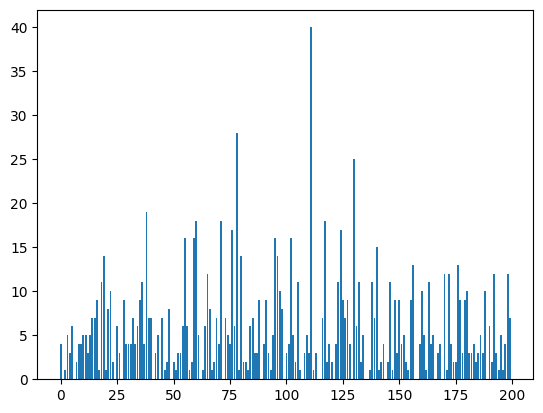

In [116]:
embedding = model.get_embedding(0, codebook, normalized=normalized)
plt.bar(list(range(len(embedding))),embedding)

### Formating for classification

In [121]:
# ---------- hyperparams -----------------
normalized=False
# ---------- hyperparams -----------------

headers = [f'feature{i}' for i in range(codebook.shape[0])]
embedding_df = pd.DataFrame(columns=headers)
labels = []

# Embedding entire dataset
for idx in tqdm(range(20)):
    embedding = model.get_embedding(idx, codebook, normalized=normalized)
    # Add a row to the DataFrame
    embedding_df.loc[len(embedding_df)] = embedding
    labels.append(label)
#     break

embedding_df['label'] = pd.Series(labels, dtype='int')

embedding_df.to_csv('embeddings_with_labels.csv', index=False)

embedding_df

100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


# Classification with embeddings

In [ ]:
import pandas as pd

# 1. Load dataset
df = pd.read_csv('/kaggle/input/bag-of-visual-words/embeddings_with_labels.csv')

In [119]:
# 2. Extract features, labels
X = df.iloc[:, 0:200]
y = df.iloc[:, 200]

# Step 3: Divide the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a basic model (Random Forest Classifier in this case)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

NameError: name 'df' is not defined

In [ ]:
# Step 7: Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print(f'Cross-validation Accuracy: {cv_scores.mean() * 100:.2f}%')


# Test

In [ ]:

# =========== Sanity check =================================
# ====================== Unit tests =================================================
def test_attributes():
    assert model.df.shape == (10662, 4)  # dataframe
    assert len(model.labels) == 23  # #labels


# test _get_item method
def test_get_item():
    image, label = model._get_item(0)
    assert len(image.shape) == 3  # image is a 3-dimensional array (h, w, c)
    assert type(label) == int and 0 <= label <= 22  # label


# test _get_descriptors method
def test_get_descriptors():
    img_descriptors = model._get_descriptors(0)
    assert len(img_descriptors.shape) == 2


# test extract all descriptors process method
def test_extract_desciptors():
    # descriptors_lake = model.extract_descriptors() # ensure output is 2d
    assert len(model.descriptors_lake.shape) == 2, "Invalid extracting process"
    # assert len(model.sample_idx) == 1000, 'Invalid sampling'


# test build_codebook method
def test_build_codebook():
    assert model.codebook.shape == (model.k, 128), "Invalid building codebook process"


# test get_embedding method
def test_get_embedding():
    embedding = model.get_embedding(0)
    assert embedding.shape[0] == model.k
    
test_attributes()
test_get_item()
test_get_descriptors()
# test_extract_desciptors()
test_build_codebook()
test_get_embedding()